In [1]:
#base
import pandas as pd
import numpy
import datetime
#使用一個jupyter notenook解析器先對.ipynb檔案進行解析，把檔案內的各個模組載入到記憶體裡供其他python檔案呼叫
%run Ipynb_importer.ipynb
#import之前寫完的財報爬蟲套件
import Season_FinancialStatement
#繪圖套件
import matplotlib.pyplot as plt

importing Jupyter notebook from Season_FinancialStatement.ipynb


In [2]:
#結構分析(財務比率)
def financial_ratio(stock_ID,year,season):
    #載入三大報表
    dfb = Season_FinancialStatement.crawl_statement(stock_ID,year,season,'資產負債表')
    dfi = Season_FinancialStatement.crawl_statement(stock_ID,year,season,'綜合損益表')
    dfc = Season_FinancialStatement.crawl_statement(stock_ID,year,season,'現金流量表')
    lseason = season-1
    if lseason==0:
        lseason=4
        year -=1
    dfb_l = Season_FinancialStatement.crawl_statement(stock_ID,year,lseason,'資產負債表')
    unified_name(dfb,dfb_l)
    #財務比率(financial_ratio)
    fr = {}
    #收益力
    fr['營業毛利率(%)'] = dfi.loc['營業毛利（毛損）淨額'][1]
    fr['營業利益率(%)'] = dfi.loc['營業利益（損失）'][1]
    fr['純益率(%)'] = dfi.loc['本期淨利（淨損）'][1]
    fr['總資產收益率(%)'] = round((dfi.loc['稅前淨利（淨損）'][0]+(dfc.loc['利息費用'][0]/season))/dfb.loc['資產總額'][0]*100,2)
    fr['股權報酬率(%)'] = round(dfi.loc['本期淨利（淨損）'][0]/dfb.loc['權益總額'][0]*100,2)
    #安定力
    fr['流動比率(%)'] = round(dfb.loc['流動資產合計'][0]/dfb.loc['流動負債合計'][0]*100,2)
    if '其他流動資產' not in dfb.index:
        fr['速動比率(%)'] = round((dfb.loc['流動資產合計'][0]-dfb.loc['存貨'][0])/dfb.loc['流動負債合計'][0]*100,2)
    else:
        fr['速動比率(%)'] = round((dfb.loc['流動資產合計'][0]-dfb.loc['存貨'][0]-dfb.loc['其他流動資產'][0])/dfb.loc['流動負債合計'][0]*100,2)
    fr['負債比率(%)'] = round(dfb.loc['負債總額'][0]/dfb.loc['資產總額'][0]*100,2)
    fr['自有資本率(%)'] = round(100-fr['負債比率(%)'],2)
    fr['固定比率(%)'] = dfb.loc['非流動資產合計'][1]
    #活動力
    fr['存貨周轉率(%)'] = round(dfi.loc['營業成本合計'][0]/(dfb.loc['存貨'][0]+dfb.loc['存貨'][2])/2/season*100,2)
    fr['存貨週轉天數(天)'] = round(90/fr['存貨周轉率(%)'],2)
    fr['應收款項周轉率(%)'] = round(dfi.loc['營業收入合計'][0]/(dfb.loc['應收帳款淨額'][0]+dfb.loc['應收帳款淨額'][2])/2/season*100,2)
    fr['應收款項週轉天數(天)'] = round(90/fr['應收款項周轉率(%)'],2)
    fr['總資產周轉率(%)'] = round(dfi.loc['營業收入合計'][0]/dfb.loc['資產總額'][0]*100,2)
    fr['自有資本周轉率(%)'] = round(dfi.loc['營業收入合計'][0]/(dfb.loc['權益總額'][0]+dfb.loc['權益總額'][2])/2/season*100,2)
    fr['固定資產周轉率(%)'] = round(dfi.loc['營業收入合計'][0]/(dfb.loc['非流動資產合計'][0]+dfb.loc['非流動資產合計'][2])/2/season*100,2)
    #成長力
    fr['營收成長率(%)'] = round((dfi.loc['營業收入合計'][0]-dfi.loc['營業收入合計'][2])/dfi.loc['營業收入合計'][2]*100,2)
    fr['營利成長率(%)'] = round((dfi.loc['營業利益（損失）'][0]-dfi.loc['營業利益（損失）'][2])/dfi.loc['營業利益（損失）'][2]*100,2)
    fr['淨資產增長率(%)'] = round(((dfb.loc['資產總額'][0]-dfb.loc['負債總額'][0])-(dfb_l.loc['資產總額'][0]-dfb_l.loc['負債總額'][0]))/(dfb_l.loc['資產總額'][0]-dfb_l.loc['負債總額'][0])*100,2)
    return fr

In [3]:
#有些財報科目名稱有變，要修改不然會出錯
def unified_name(*args):
    for df in args:
        if '資產總計' in df.index:
            df.rename(index={'資產總計':'資產總額','負債總計':'負債總額','權益總計':'權益總額'},inplace=True) 
    return 

In [4]:
#趨勢分析(近三年)
def trend_analysis(stock_ID):
    trend = {}
    date = datetime.datetime.now()
    year = date.year
    season = int(date.month/3)
    count = 0
    while count<12:
        if season==0:
            season=4
            year-=1
        try:
            trend['%d-%d'%(year,season)] = financial_ratio(stock_ID,year,season)
            count +=1
            season -=1
        except:
            print('error.')
            return
    trend = pd.DataFrame(trend).T
    return trend

In [5]:
"""
畫四張不同財務指數組成的分析圖，分別為:收益力、安定力、活動力、成長力
"""
#收益力
def draw_Profitability(df,ax):
    ax.set_xlabel('season', color='brown')
    ax.tick_params(width=2,colors='brown')
    feature = {'營業毛利率(%)':'Gross Profit',
               '營業利益率(%)':'Operating Income',
               '純益率(%)':'Net Income',
               '總資產收益率(%)':'ROTA',
               '股權報酬率(%)':'ROE'}
    for i,e in feature.items():
        ax.plot(df[i],label=e,marker='o')
    ax.legend(loc='best')
    ax.set_title('Profitability',color='tab:blue')
    ax.set_ylabel('ratio(%)', color='brown')
    return 
#安定力
def draw_Stability(df,ax):
    ax.set_xlabel('season', color='brown')
    ax.tick_params(width=2,colors='brown')
    feature = {'流動比率(%)':'Current ratio',
               '速動比率(%)':'Quick ratio',
               '負債比率(%)':'Debt ratio',
               '自有資本率(%)':'equity capital',
               '固定比率(%)':'Fixed ratio'}
    for i,e in feature.items():
        ax.plot(df[i],label=e,marker='o')
    ax.legend(loc='best')
    ax.set_title('Stability',color='tab:blue')
    ax.set_ylabel('ratio(%)', color='brown')
    return
#活動力
def draw_Activity(df,ax):
    ax.set_xlabel('season', color='brown')
    ax.tick_params(width=2,colors='brown')
    feature = {'存貨周轉率(%)':'Inventory turnover',
               '應收款項周轉率(%)':'Accounts receivable turnover',
               '總資產周轉率(%)':'Total asset turnover',
               '自有資本周轉率(%)':'Own capital turnover',
               '固定資產周轉率(%)':'Fixed asset turnover'}
    for i,e in feature.items():
        ax.plot(df[i],label=e,marker='o')
    ax.legend(loc='best')
    ax.set_title('Activity',color='tab:blue')
    ax.set_ylabel('ratio(%)', color='brown')
    return
#成長力
def draw_Growth(df,ax):
    ax.set_xlabel('season', color='brown')
    ax.tick_params(width=2,colors='brown')
    feature = {'營收成長率(%)':'Revenue growth rate',
               '營利成長率(%)':'Profit growth rate',
               '淨資產增長率(%)':'Net asset growth rate'}
    for i,e in feature.items():
        ax.plot(df[i],label=e,marker='o')
    ax.legend(loc='best')
    ax.set_title('Growth',color='tab:blue')
    ax.set_ylabel('ratio(%)', color='brown')
    return

In [6]:
def draw(df):
    plt.style.use('seaborn')
    fig,axes = plt.subplots(2,2,figsize=(24, 8))
    plt.subplots_adjust(wspace =0.1,hspace =0.3)
    draw_Profitability(df,axes[0,0])
    draw_Stability(df,axes[0,1])
    draw_Activity(df,axes[1,0])
    draw_Growth(df,axes[1,1])
    return

In [7]:
stock_ID = input('Stock ID')

Stock ID 2330


In [8]:
df = trend_analysis(stock_ID)
df

,營業毛利率(%),營業利益率(%),純益率(%),總資產收益率(%),股權報酬率(%),流動比率(%),速動比率(%),負債比率(%),自有資本率(%),固定比率(%),存貨周轉率(%),存貨週轉天數(天),應收款項周轉率(%),應收款項週轉天數(天),總資產周轉率(%),自有資本周轉率(%),固定資產周轉率(%),營收成長率(%),營利成長率(%),淨資產增長率(%)
2019-3,47.57,36.82,34.50,5.30,6.37,171.68,147.62,25.62,74.38,60.20,12.81,7.03,17.90,5.03,13.73,1.50,2.02,12.56,13.27,2.13
2019-2,43.04,31.66,27.71,3.64,4.30,162.34,141.79,30.59,69.41,54.89,16.24,5.54,24.66,3.65,10.76,1.86,2.54,3.31,-9.62,-10.85
2019-1,41.31,29.38,28.07,3.16,3.52,262.07,229.21,20.29,79.71,54.68,30.28,2.97,46.52,1.93,10.00,3.20,4.68,-11.84,-33.63,3.94
2018-4,48.27,37.19,34.05,19.05,20.94,279.46,242.10,19.74,80.26,54.47,37.65,2.39,51.63,1.74,49.35,4.03,5.67,5.53,-0.50,6.45
2018-3,47.39,36.58,34.22,5.06,5.65,267.15,228.10,20.00,80.00,56.38,12.74,7.06,17.43,5.16,13.22,1.40,1.93,3.27,-2.87,5.72
2018-2,47.81,36.19,30.99,4.30,4.85,207.14,181.49,27.41,72.59,53.30,17.59,5.12,28.01,3.21,11.36,1.94,2.62,9.08,1.41,-7.22
2018-1,50.33,39.03,36.19,4.92,5.59,271.48,231.50,21.60,78.40,54.66,38.69,2.33,54.47,1.65,12.11,3.96,5.50,6.06,1.55,5.51
2017-4,50.62,39.45,35.11,19.93,22.53,238.97,215.17,23.55,76.45,56.96,49.22,1.83,48.98,1.84,49.07,4.19,5.55,3.11,2.01,6.38
2017-3,49.93,38.89,35.68,5.50,6.28,236.12,207.91,22.27,77.73,61.72,17.16,5.24,17.08,5.27,13.69,1.49,1.91,-3.19,-7.72,6.63
2017-2,50.83,38.93,30.99,4.38,4.94,160.08,147.24,32.42,67.58,57.81,23.95,3.76,22.44,4.01,10.77,1.96,2.41,-3.59,-8.83,-7.82


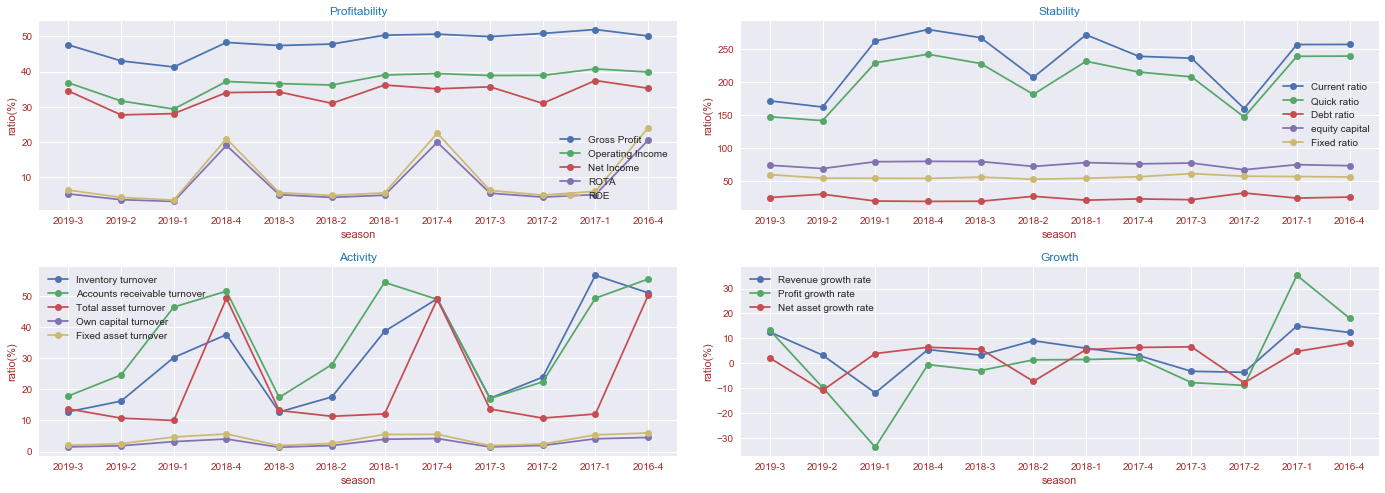

In [9]:
draw(df)